# Compute the Planck CMB temperature power spectrum with healpy
tags: [healpy,cmb,cosmology]

In [1]:
import healpy as hp
import numpy as np
import os
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook we will load the Planck CMB-only temperature map and try to reproduce the Planck CMB power spectrum in temperature just using `healpy`.

## Load data

First we load the Planck data release 3 CMB-only temperature produced by Commander by separating it out from galactic foregrounds:

In [2]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander_2048_R3.00_full.fits

--2021-02-28 09:59:21--  https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander_2048_R3.00_full.fits
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.87
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610660160 (1.5G) [image/x-fits]
Saving to: ‘COM_CMB_IQU-commander_2048_R3.00_full.fits’

COM_CMB_IQU-command 100%[===================>]   1.50G  43.1MB/s    in 29s     

2021-02-28 09:59:50 (53.4 MB/s) - ‘COM_CMB_IQU-commander_2048_R3.00_full.fits’ saved [1610660160/1610660160]



In [3]:
filename = 'COM_CMB_IQU-commander_2048_R3.00_full.fits'
cmb_map = hp.read_map(filename)

/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".forma

In [4]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits

--2021-02-28 09:59:53--  https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.87
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201335040 (192M) [image/x-fits]
Saving to: ‘COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits’

COM_Mask_CMB-common 100%[===================>] 192.01M  61.8MB/s    in 3.1s    

2021-02-28 09:59:57 (61.8 MB/s) - ‘COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits’ saved [201335040/201335040]



/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zonca/miniconda3/envs/so/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you wi

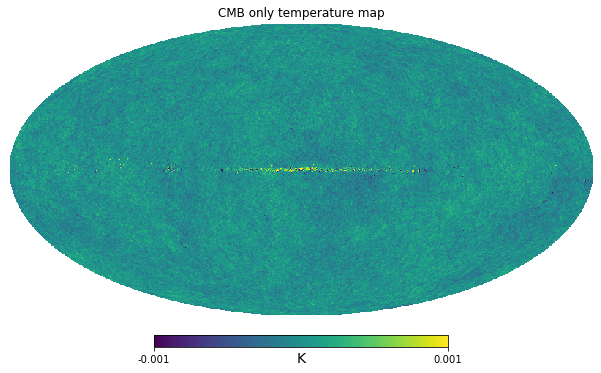

In [5]:
hp.mollview(cmb_map, min=-1e-3, max=1e-3, title="CMB only temperature map", unit="K")

We see there is residual galactic emission we should mask. The contamination just close to the galactic plane, so we could run `anafast` and specify a few degrees of `gal_cut`.

However, let's exercise also how to use one of the Planck mask and use it to mask:

In [6]:
path = 'COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits'
mask = hp.read_map(path)
map_masked = hp.ma(cmb_map)
map_masked.mask = np.logical_not(mask)

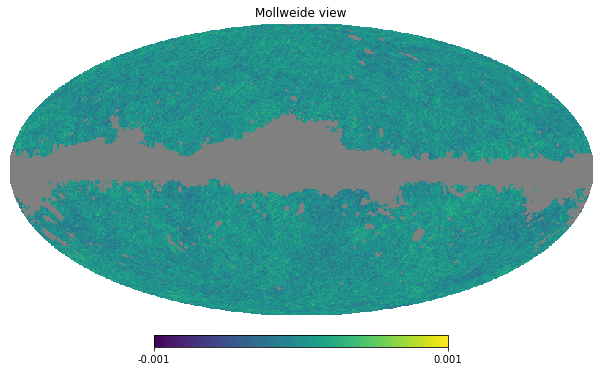

In [7]:
hp.mollview(map_masked, min=-1e-3, max=1e-3)

Finally we load the binned TT CMB power spectrum that will be our target:

In [8]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-TT-binned_R3.01.txt

--2021-02-28 10:00:04--  https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-TT-binned_R3.01.txt
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.87
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7143 (7.0K) [text/plain]
Saving to: ‘COM_PowerSpect_CMB-TT-binned_R3.01.txt.2’

COM_PowerSpect_CMB- 100%[===================>]   6.98K  --.-KB/s    in 0s      

2021-02-28 10:00:04 (174 MB/s) - ‘COM_PowerSpect_CMB-TT-binned_R3.01.txt.2’ saved [7143/7143]



In [9]:
!head -3 COM_PowerSpect_CMB-TT-binned_R3.01.txt

# l                Dl               -dDl             +dDl             BestFit          
  4.77112240e+01   1.47933552e+03   5.07654876e+01   5.07654876e+01   1.46111304e+03
  7.64716065e+01   2.03496833e+03   5.47101576e+01   5.47101576e+01   2.06238073e+03


In [10]:
cmb_binned_spectrum = np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt')

## Compute the power spectrum

* Always use `use_pixel_weights=True` in `anafast` to have a more precise spectrum estimation
* If you compute the spectrum on the partial sky, first order correction is to divide by the sky fraction to retrieve the spectrum over the full sky

In [11]:
lmax = 3000

In [12]:
test_cls_meas_frommap = hp.anafast(map_masked, lmax=lmax, use_pixel_weights=True)

In [13]:
ll = np.arange(lmax+1)

In [14]:
sky_fraction = len(map_masked.compressed()) / len(map_masked)

In [15]:
print(f"The map covers {sky_fraction:.1%} of the sky")

The map covers 77.9% of the sky


In [16]:
plt.style.use("seaborn-poster")

In [17]:
k2muK = 1e6

Power spectra are generally plotted as $D_\ell$ which is defined as $\dfrac{\ell(\ell+1)}{2 \pi}C_\ell$,
so we need to apply that factor to the $C_\ell$ calculated from the map.

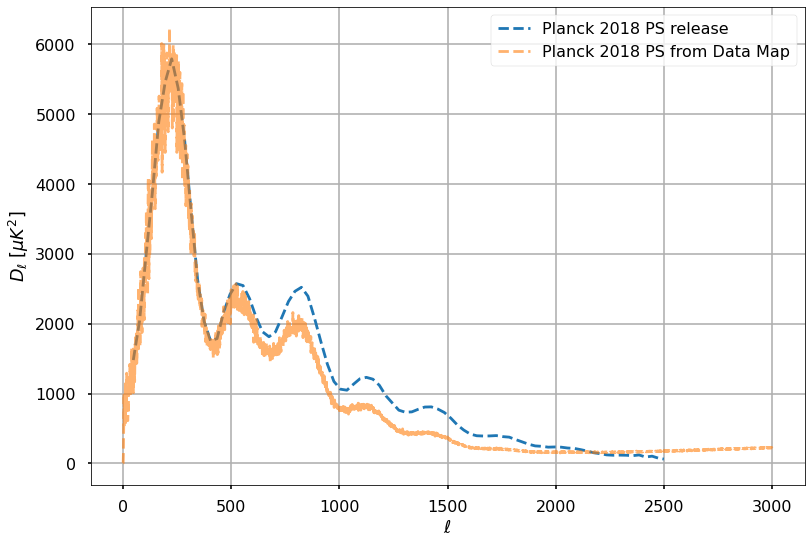

In [18]:
plt.plot(cmb_binned_spectrum[:,0], cmb_binned_spectrum[:,1], '--', alpha=1, label='Planck 2018 PS release')
plt.plot(ll, ll*(ll+1.)*test_cls_meas_frommap*k2muK**2/2./np.pi / sky_fraction, '--', alpha=0.6, label='Planck 2018 PS from Data Map')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.grid()
plt.legend(loc='best')

Good, we can reproduce the first peak, but we see that power at small scales is suppressed due to the beam.

## Correct for the beam

Reading the documentation of the Planck commander release we see that the output has a resolution of 5 arcminutes. Therefore as a first order correction of the beam, we can divide the power spectrum by the square of the beam window function.

In [19]:
w_ell = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=lmax)

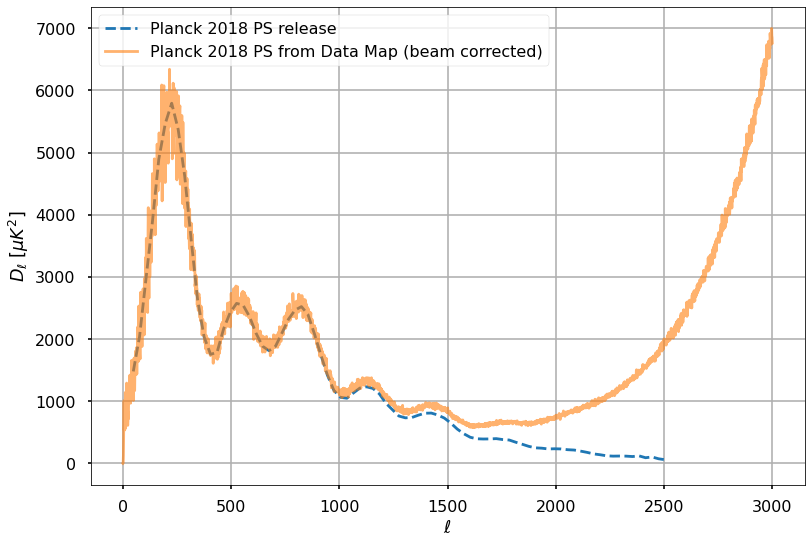

In [20]:
plt.plot(cmb_binned_spectrum[:,0], cmb_binned_spectrum[:,1], '--', alpha=1, label='Planck 2018 PS release')
plt.plot(ll, ll*(ll+1.)*test_cls_meas_frommap*k2muK**2/2./np.pi / sky_fraction / w_ell**2,
         alpha=0.6, label='Planck 2018 PS from Data Map (beam corrected)')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.grid()
plt.legend(loc='best');

Very good, we were also be able to reproduce the second and third peak, after $\ell$ of about 1000, we start to overestimate the power spectrum.

This is as far as we can go with only `healpy`, the next step would be to properly handle the effect of masking. Computing the power spectrum on a masked map tends to create coupling between different scales, so power at large scales can contaminate the power spectrum at smaller scales. Next we can compute the power spectrum with a more sophisticated tool like `NaMaster` <https://github.com/LSSTDESC/NaMaster> which can correct for that.